In [8]:
from kubernetes import client, config
import json
import matplotlib.pyplot as plt
import numpy as np

In [12]:
config.load_kube_config()
graph_dir = "graphs/"
cs = ['tab:red', 'tab:blue', 'tab:green', 'tab:orange', 'tab:purple', 'tab:brown']


# Consensus Stats

In [4]:
stats_name = ['msg rcv total',
              'msg sent total',
              'comp time per iter',
              'xchg time per iter',
              'avg time per iter',
              'total time',
              'total iter',
              'setup time']

In [5]:
def read_metrics():
    metrics = {}

    v1 = client.CoreV1Api()
    ret = v1.list_pod_for_all_namespaces(watch=False)
    for i in ret.items:
        if i.metadata.name.startswith("my-scheduler-") or i.metadata.name.startswith("my-controller"):
            # print(f"{i.metadata.name} {i.status.pod_ip}")
            lines = v1.read_namespaced_pod_log(
                name=i.metadata.name, namespace=i.metadata.namespace)

            name = i.metadata.name
            if name.startswith('my-scheduler-'):
                metrics[name] = {}
            for line in lines.split('\n'):
                if name.startswith('my-sched') and line.startswith('{'):
                    d = json.loads(line)
                    for sn in stats_name:
                        if sn.endswith('per iter'):
                            if not sn in metrics[name]:
                                metrics[name][sn] = []
                            if sn in d:
                                metrics[name][sn].append(d[sn])
                        else:
                            if sn in d:
                                metrics[name][sn] = d[sn]
    return metrics

## stats per pod

Plot stats, large variance in computation time per iteration is perhaps due to the
short period of computation leading to incorrect timing measurement

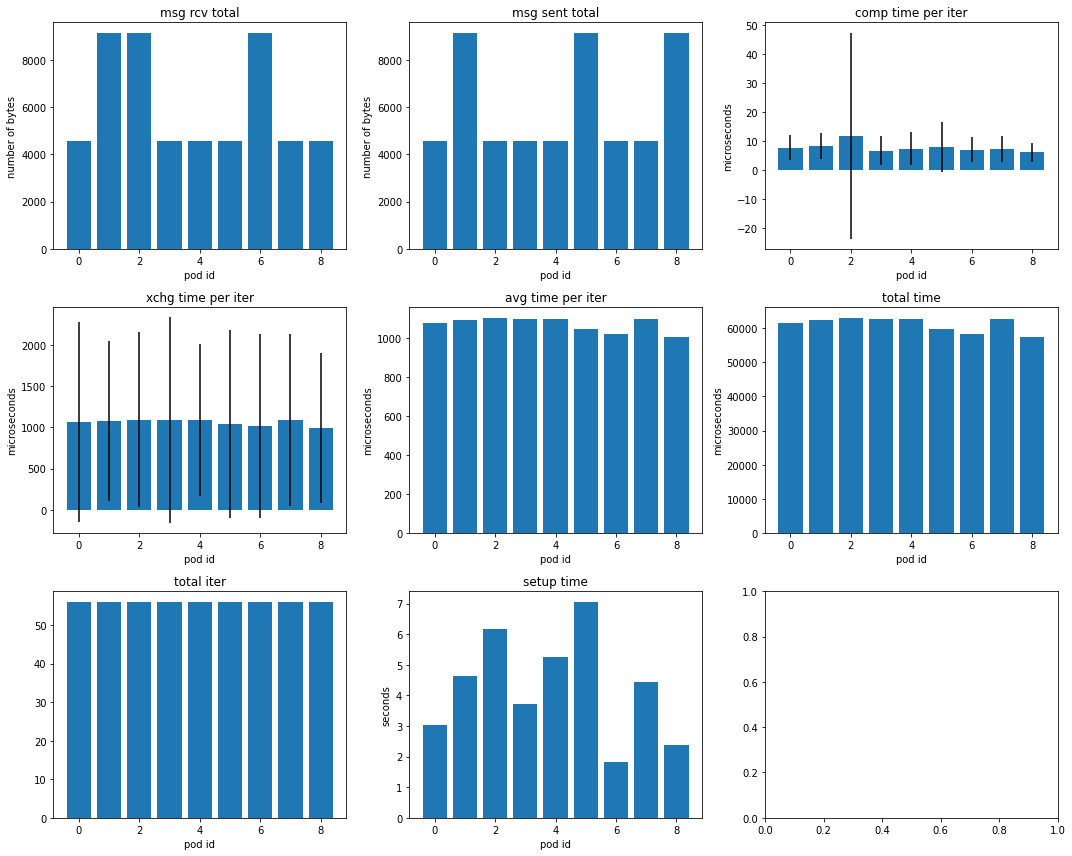

In [10]:
fig, ax = plt.subplots(3, 3)
fig.set_size_inches(15, 12)

x = range(len(metrics.keys()))


for i, sn in enumerate(stats_name):
    y = []
    a = ax[i // 3][i % 3]
    a.set_xlabel('pod id')
    if i in [0, 1]:
        a.set_ylabel('number of bytes')
    elif i in [2, 3, 4, 5]:
        a.set_ylabel("microseconds")

    if sn.find('total') != -1:
        for name in metrics:
            y.append(metrics[name][sn])
        a.bar(x, y)
        a.set_title(sn)

    elif sn.find('per iter') != -1:
        for name in metrics:
            d = np.array(metrics[name][sn])
            mean = np.mean(d)
            std = np.std(d)
            y.append([mean, std])
        y = np.array(y)
        a = ax[i // 3][i % 3]
        a.bar(x, y[:, 0], yerr = y[:, 1])
        a.set_title(sn)

    elif sn.find('setup time') != -1:
        for name in metrics:
            y.append(metrics[name]['fields.time'])
        a = ax[i // 3][i % 3]
        a.bar(x, y)
        a.set_title(sn)
        a.set_ylabel('seconds')


fig.tight_layout()
fig.savefig(f'{graph_dir}metrics-{p}pods.png')



## Stats against number of pods

In [45]:
dirs = ['data/2022-08-15T']
metrics = {}
pods = range(100, 1000, 100)
runs = range(11)
for p in pods:
  with open(f'data/data-{p}pods.json', 'r') as f:
    for line in f:
      metrics[p] = json.loads(line)
print(metrics[100]['0']['my-scheduler-c5648b7d-22lrq']['setup time'])

29.934439289


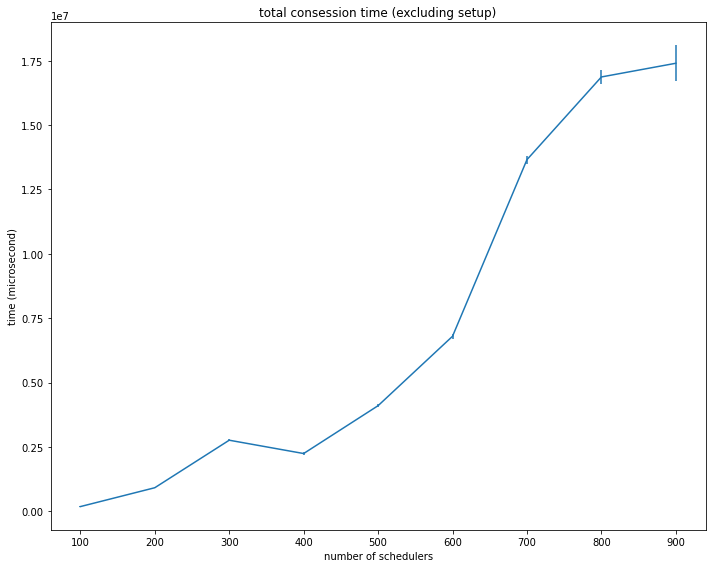

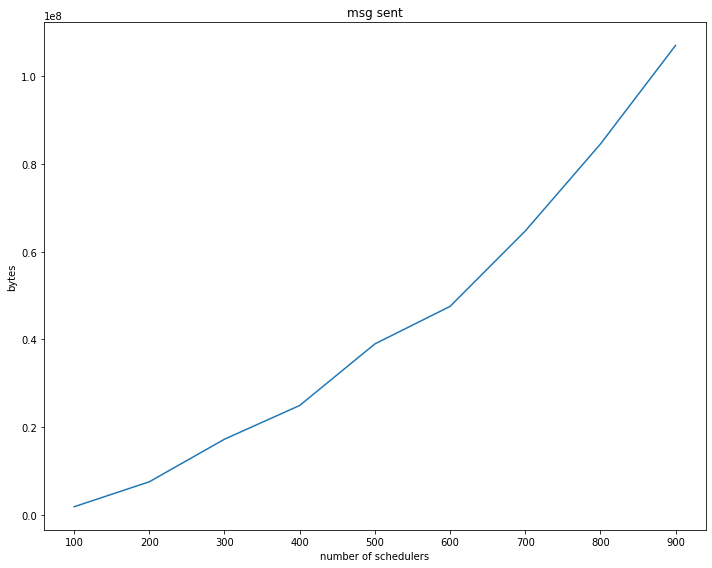

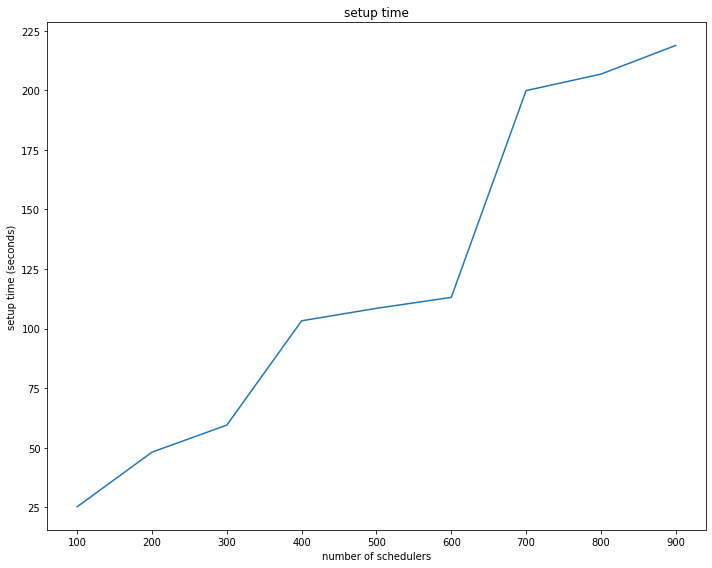

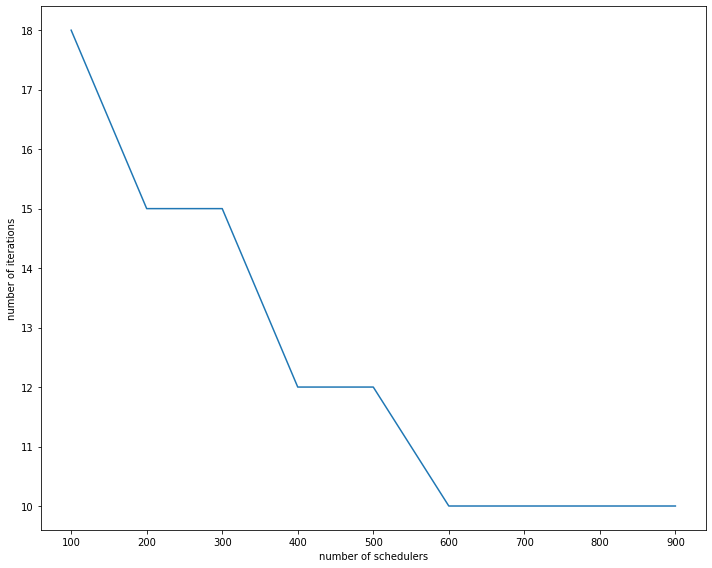

In [52]:

x = pods
y_time = []
y_msg_sent = []
y_setup = []
y_iter = []

for p in pods:
  t1 = []
  for r in runs:
    r = str(r)
    t2 = np.array([metrics[p][r][name]['total time'] for name in metrics[p][r]])
  t1.append(np.mean(t2))

  y_time.append([np.mean(t2), np.std(t2)])

  t1 = []
  for r in runs:
    r = str(r)
    t2 = np.array([metrics[p][r][name]['msg sent total'] for name in metrics[p][r]])
  t1.append(np.sum(t2))
  y_msg_sent.append([np.mean(t1), np.std(t1)])

  t2 = np.array([metrics[p]['0'][name]['setup time'] for name in metrics[p][r]])
  y_setup.append(np.mean(t2))


  t2 = np.array([metrics[p]['0'][name]['total iter'] for name in metrics[p][r]])
  y_iter.append(np.mean(t2))


  
y_time = np.array(y_time)
y_msg_sent = np.array(y_msg_sent)



fig, ax = plt.subplots()
fig.set_size_inches(10, 8)

# -------- latency --------- #

ax.errorbar(x, y_time[:, 0], yerr = y_time[:, 1])
ax.set_title('total consensus time (excluding setup)')
ax.set_xlabel('number of schedulers')
ax.set_ylabel('time (microsecond)')

fig.tight_layout()
fig.savefig(f'{graph_dir}latency.png')

fig, ax = plt.subplots()
fig.set_size_inches(10, 8)

# -------- msg sent --------- #

ax.errorbar(x, y_msg_sent[:, 0], yerr = y_msg_sent[:, 1])
ax.set_title('msg sent')
ax.set_xlabel('number of schedulers')
ax.set_ylabel('bytes')

fig.tight_layout()
fig.savefig(f'{graph_dir}message.png')


# -------- setup time --------- #

fig, ax = plt.subplots()
fig.set_size_inches(10, 8)
ax.plot(x, y_setup)
ax.set_title('setup time')
ax.set_xlabel('number of schedulers')
ax.set_ylabel('setup time (seconds)')
fig.tight_layout()
fig.savefig(f'{graph_dir}setup_time.png')


#------ iteration -------- #
fig, ax = plt.subplots()
fig.set_size_inches(10, 8)
ax.plot(x, y_iter)
ax.set_xlabel('number of schedulers')
ax.set_ylabel('number of iterations')
fig.tight_layout()
fig.savefig(f'{graph_dir}iter.png')



## CPU and Memory

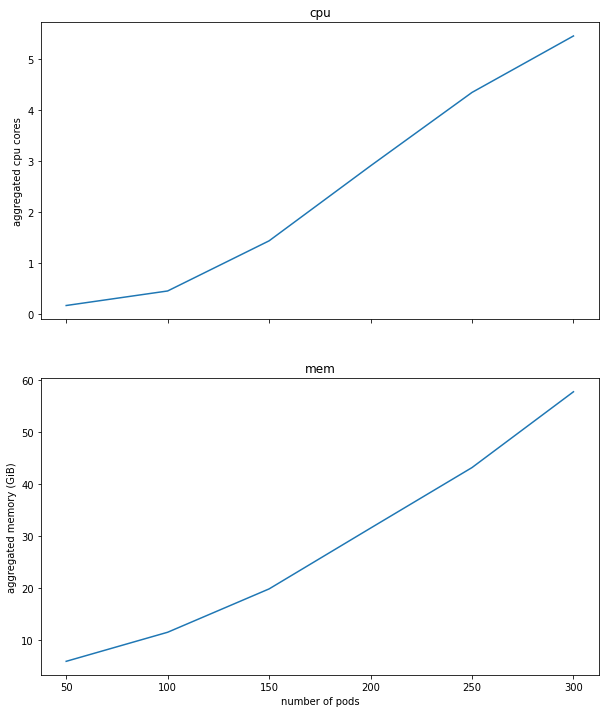

In [20]:
cpu = [0.17, 0.455, 1.438, 2.908, 4.347, 5.454]
mem = [5.97, 11.55, 19.87, 31.54, 43.16, 57.71]
pods = range(50, 350, 50)


fig, ax = plt.subplots(2, 1, sharex=True)
fig.set_size_inches(10, 12)

ax[0].plot(pods, cpu, label='cpu')
ax[0].set_title('cpu')
ax[0].set_ylabel('aggregated cpu cores')

ax[1].plot(pods, mem, label='mem')
ax[1].set_title('mem')
ax[1].set_ylabel('aggregated memory (GiB)')
ax[1].set_xlabel('number of pods')

fig.savefig(f'{graph_dir}cpu-and-memory-usage.png')

# Placement Stats

## Capacity left

In [3]:
# --- uniform distribution --- #
# dirs = ['data/2022-08-11T18-01-42/', 'data/2022-08-11T18-06-46/', 'data/2022-08-11T18-12-00/', 'data/2022-08-11T18-18-56/']

# --- gaussian distribtuion --- #
# dirs = ['data/2022-08-16T11-19-32', 'data/2022-08-16T11-23-20', 'data/2022-08-16T11-27-08', 'data/2022-08-16T11-31-12']

# --- gaussian with jobs --- #
dirs = ['data/2022-08-16T13-41-06', 'data/2022-08-16T13-50-14', 'data/2022-08-16T13-53-15', 'data/2022-08-16T14-00-30']

# --- gaussian with scheduled jobs --- #
dirs = ['data/2022-08-16T17-03-38', 'data/2022-08-16T17-07-26', 'data/2022-08-16T17-12-57', 'data/2022-08-16T17-20-12']

In [4]:
pl = [{} for _ in range(len(dirs))]
pods = [(i+1) * 100 for i in range(len(dirs))]
runs = range(10)
for i, dir in enumerate(dirs):
  with open(f'{dir}/placement-{(i+1) * 100}pods-60cap-2c.json', 'r') as f:
    for l in f:
      pl[i] = json.loads(l)

In [5]:
final_ws = []
left_elements = []
sched_elements = []
generated_jobs = []
sched_pcts = []
for i in range(len(dirs)):
  final_w = []
  for k, v in pl[i]['0'].items():
    if k == 'my-controller':
      left_elements.append(np.array(v['left elements']))
      sched_elements.append(v['scheduled elements'])
      generated_jobs.append(v['generated jobs'])
    else:
      final_w.append(v['final w'])
  final_ws.append(np.array(final_w))

  sched_pct = []
  for r in runs:
    for k, v in pl[i][str(r)].items():
      if k == 'my-controller':
        sched_pct.append(len(v['scheduled elements']) / len(v['generated jobs']))
  sched_pct = np.array(sched_pct)
  sched_pcts.append([np.mean(sched_pct), np.std(sched_pct)])

sched_pcts = np.array(sched_pcts)

# print(final_ws)
# print(f'sum is {np.sum(final_w)}')
# print(f'mean is {np.mean(final_w)}')
# print(f'std is {np.std(final_w)}')
# print(f'elements left are {left_elements}')




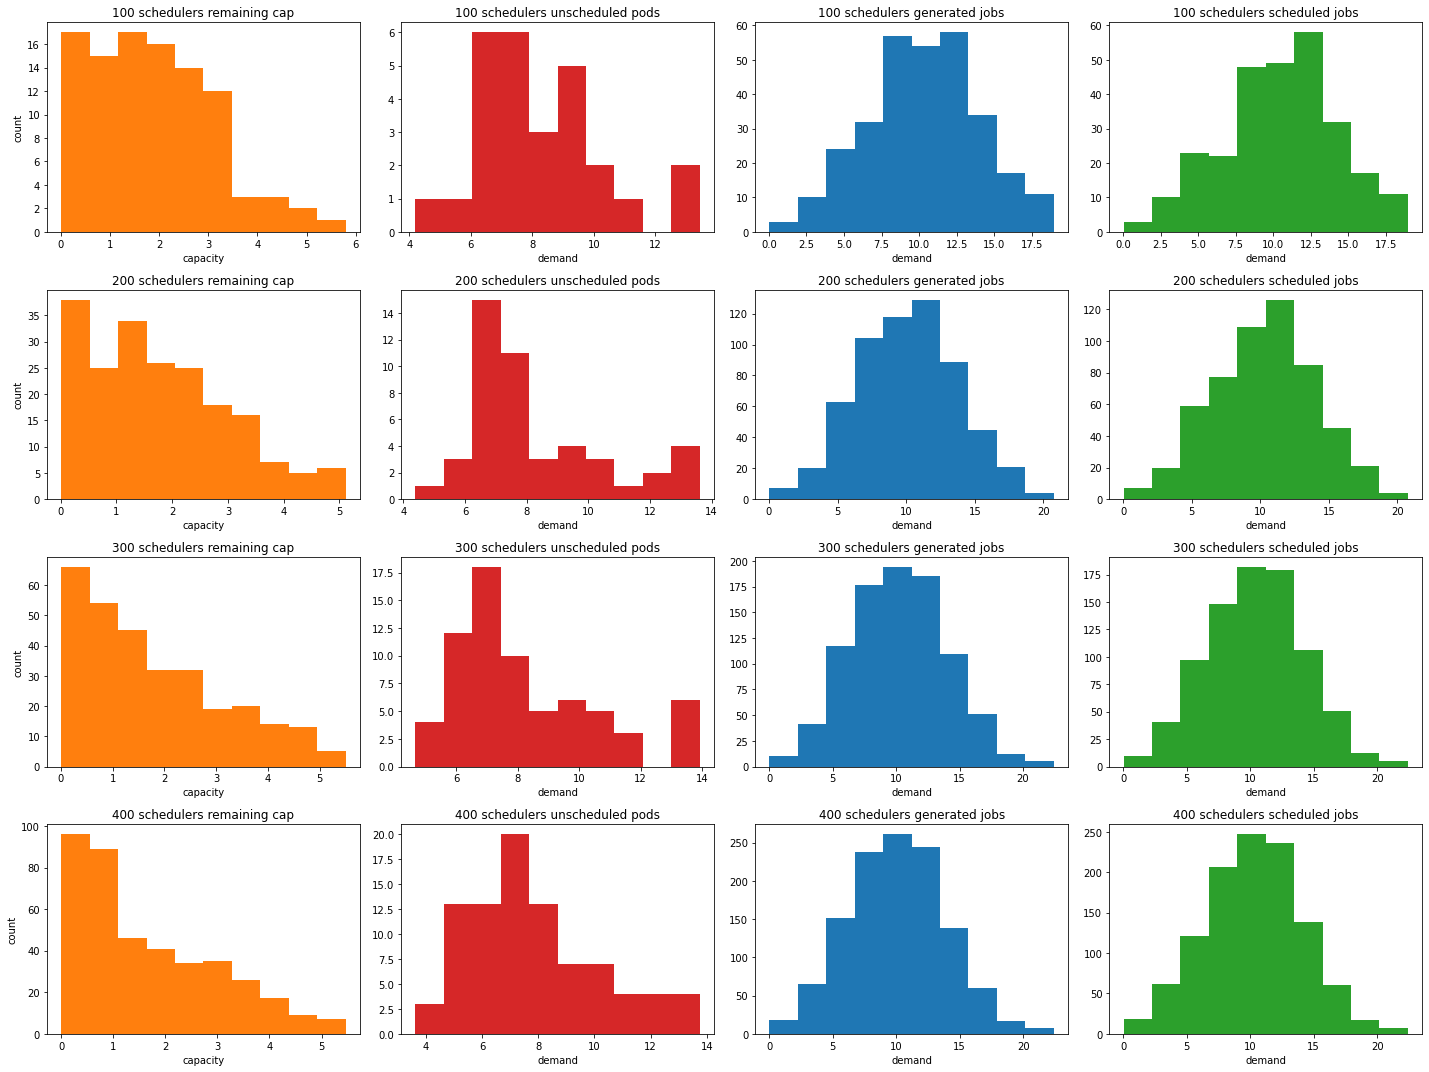

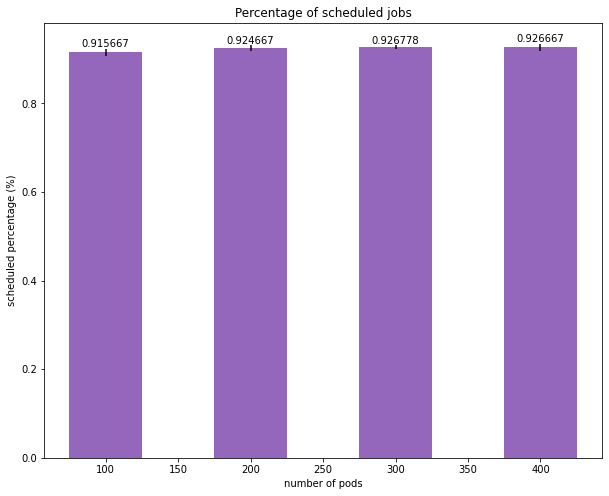

In [6]:
fig, ax = plt.subplots(nrows=4, ncols=4)
fig.set_size_inches(20, 15)


for i in range(len(dirs)):
  ax[i][0].hist(final_ws[i], color='tab:orange')
  ax[i][1].hist(left_elements[i], color='tab:red')
  ax[i][2].hist(generated_jobs[i], color='tab:blue')
  ax[i][3].hist(sched_elements[i], color='tab:green')

  ax[i][0].set_title(f'{(i+1)*100} schedulers remaining cap')
  ax[i][1].set_title(f'{(i+1)*100} schedulers unscheduled pods')
  ax[i][2].set_title(f'{(i+1)*100} schedulers generated jobs')
  ax[i][3].set_title(f'{(i+1)*100} schedulers scheduled jobs')


  ax[i][0].set_xlabel('capacity')
  ax[i][1].set_xlabel('demand')
  ax[i][2].set_xlabel('demand')
  ax[i][3].set_xlabel('demand')


  ax[i][0].set_ylabel('count')
  # ax.axhline(sl)

fig.tight_layout()



# fig.savefig(f'{graph_dir}placement-histograms.png')

fig, ax = plt.subplots()
fig.set_size_inches(10, 8)
b = ax.bar(pods, sched_pcts[:, 0], width=50, yerr=sched_pcts[:, 1], color='tab:purple')
ax.bar_label(b, label_type='edge')
ax.set_title('Percentage of scheduled jobs')
ax.set_xlabel('number of pods')
ax.set_ylabel('scheduled percentage (%)')


# fig.savefig(f'{graph_dir}gaussian-schedpct.png')

## Time taken

In [21]:
# dirs = ['data/2022-08-15T14-59-24', 'data/2022-08-15T15-02-56', 'data/2022-08-15T15-08-12',
#   'data/2022-08-15T15-15-12', 'data/2022-08-15T15-46-44', 'data/2022-08-15T15-51-43']
# ---- uniform distribtuion ---- #
# dirs = ['data/2022-08-15T16-00-21', 'data/2022-08-15T16-04-29', 'data/2022-08-15T16-06-44',
#   'data/2022-08-15T16-10-19', 'data/2022-08-15T16-16-32']
# ---- gaussian distribution ---- #
dirs = ['data/2022-08-16T11-19-32', 'data/2022-08-16T11-23-20', 'data/2022-08-16T11-27-08','data/2022-08-16T11-31-12']

pods = range(100, (len(dirs) + 1) * 100, 100)

metrics = {}
runs = range(10)

for i, dir in enumerate(dirs):
  with open(f'{dir}/consensus-{pods[i]}pods.json', 'r') as f:
    for line in f:
      metrics[pods[i]] = json.loads(line)
x = pods
y_time = []
y_setup = []

for p in pods:
  t1 = []
  for r in runs:
    r = str(r)
    t2 = np.array([metrics[p][r][name]['total time'] for name in metrics[p][r]])
    t1.append(np.mean(t2))
  print(t1, np.std(t1))
  y_time.append([np.mean(t1), np.std(t1)])

  t2 = np.array([metrics[p]['0'][name]['setup time'] for name in metrics[p][r]])
  y_setup.append(np.mean(t2))


y_time = np.array(y_time)


pl_times = []
# jobs_size = []
for i, dir in enumerate(dirs):
  with open(f'{dir}/placement-{pods[i]}pods-60cap-2c.json', 'r') as f:
    for l in f:
      pl = json.loads(l)
      ts = []
      js = []
      for j in runs:
        ts.append(pl[str(j)]['my-controller']['time taken'])
      ts = np.array(ts)
      js = np.array(js)
      pl_times.append([np.mean(ts), np.std(ts)])

pl_times = np.array(pl_times)


total_times = y_time + pl_times
# jobs_size = np.array(jobs_size)



[204992.19, 187003.65, 201193.82, 233378.45, 204767.08, 206908.42, 226595.13, 216551.0, 205714.11, 208753.25] 12455.81446902129
[1225743.835, 734966.685, 712196.97, 1182001.32, 894470.295, 692617.445, 696519.505, 962209.215, 695112.435, 831406.295] 192156.56918124144
[2047494.5433333332, 1453821.56, 1829772.1166666667, 1641134.79, 1998512.92, 2163989.453333333, 1638261.4433333334, 1643432.3233333332, 1663595.6133333333, 1993444.3833333333] 220289.20907212628
[3118041.68, 3105092.65, 3332186.75, 3022989.3525, 2924261.4, 3318928.1775, 3598849.725, 3283392.535, 3504763.125, 3927719.76] 285323.96212615154


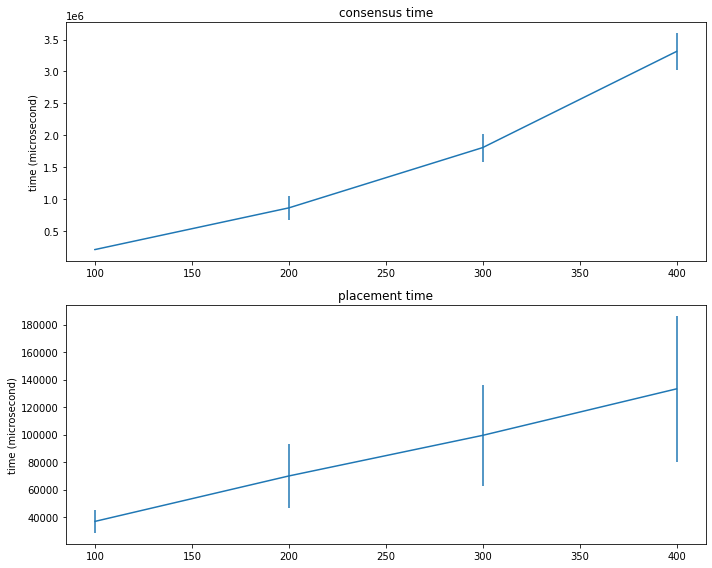

In [14]:
fig, ax = plt.subplots(nrows=2, ncols=1)
fig.set_size_inches(10, 8)



# ax.semilogy(x, y_time[:, 0], label='consensus time')
# ax.semilogy(pods, pl_times[:,0], label='placement time')
# ax.semilogy(pods, total_times[:, 0], label='total time')
# ax.legend()

ax[0].errorbar(x, y_time[:, 0], yerr = y_time[:, 1], label='consensus time')
ax[0].set_title('consensus time')
ax[0].set_ylabel('time (microsecond)')
ax[1].errorbar(pods, pl_times[:,0], yerr = pl_times[:,1], label='placement time')
ax[1].set_title('placement time')
ax[1].set_ylabel('time (microsecond)')


# ax[2].bar(x, jobs_size[:, 0], width= 50,yerr = jobs_size[:, 1])
# ax[2].set_ylabel("number of jobs")
# ax[2].set_title("number of jobs")
# ax[2].set_xlabel('number of schedulers')

fig.tight_layout()
# fig.savefig(f'{graph_dir}latency-both-gaussian.png')

## Against number of jobs

In [11]:
dirs = [
  # ---- 100 pods ---- #
  ['data/2022-08-17T14-16-14', 'data/2022-08-17T14-19-24', 'data/2022-08-17T14-21-41', 'data/2022-08-17T14-25-30', 'data/2022-08-17T14-29-30'],
  # ---- 200 pods ---- #
  ['data/2022-08-17T14-37-57', 'data/2022-08-17T14-41-36', 'data/2022-08-17T14-45-15', 'data/2022-08-17T14-48-53', 'data/2022-08-17T14-52-32'],
  # ---- 300 pods ---- #
  ['data/2022-08-17T15-06-07', 'data/2022-08-17T15-11-31', 'data/2022-08-17T15-16-55', 'data/2022-08-17T15-19-33', 'data/2022-08-17T15-22-35'],
  # ---- 400 pods ---- #
  ['data/2022-08-17T15-33-05', 'data/2022-08-17T15-36-44', 'data/2022-08-17T15-43-53', 'data/2022-08-17T15-51-03', 'data/2022-08-17T15-54-43']
]

pods = range(100, (len(dirs)+1) * 100, 100)
jf = [0.5, 1.0, 2.0, 3.0, 4.0, 5.0]

total_pod_times = []
con_pod_times = []
pl_pod_times = []
sched_pod_pcts = []
pod_jobs = []


for pidx, p in enumerate(pods):
  jobs = [jf[i] * p for i in range(len(dirs[pidx]))]
  pod_jobs.append(jobs)

  metrics = {}
  runs = range(10)


  total_times = []
  con_times = []
  pl_times = []
  sched_pcts = []

  for i, dir in enumerate(dirs[pidx]):
    t1 = []
    with open(f'{dir}/consensus-{p}pods-{jf[i]}jobs.json', 'r') as f:
      con = json.loads(f.readline())
      for r in runs:
        r = str(r)
        t2 = np.array([con[r][name]['total time'] for name in con[r]])
        t1.append(np.mean(t2))
      if pidx == 0:
        print(t1)
      con_times.append([np.mean(t1), np.std(t1)])

    t2 = []
    sched_pct = []
    with open(f'{dir}/placement-{p}pods-{jf[i]}jobs.json', 'r') as f:
      for l in f:
        pl = json.loads(l)
        for r in runs:
          t2.append(pl[str(r)]['my-controller']['time taken'])
        t2 = np.array(t2)
        pl_times.append([np.mean(t2), np.std(t2)])


        for r in runs:
          v = pl[str(r)]['my-controller']
          pct = len(v['scheduled elements']) / len(v['generated jobs'])
          sched_pct.append(pct)
        sched_pct = np.array(sched_pct)

        sched_pcts.append([np.mean(sched_pct), np.std(sched_pct)])


    total_times.append([np.mean(t1 + t2), np.std(t1 + t2)])  




  con_times = np.array(con_times)
  pl_times = np.array(pl_times)
  total_times = np.array(total_times)
  sched_pcts = np.array(sched_pcts)

  con_pod_times.append(con_times)
  pl_pod_times.append(pl_times)
  total_pod_times.append(total_times)
  sched_pod_pcts.append(sched_pcts)


  # print(con_times)
  # print(pl_times)
  # print(total_times)
  # jobs_size = np.array(jobs_size)



[223470.1, 237713.03, 212333.57, 210353.83, 208471.64, 208258.25, 216106.7, 206522.82, 205862.62, 214661.14]
[372581.26, 171806.26, 167152.76, 202667.48, 172745.34, 200663.46, 197942.96, 178137.99, 398929.8, 196194.68]
[222640.41, 177061.55, 184643.28, 192637.78, 234599.57, 175635.9, 179313.36, 204370.69, 212238.16, 180718.64]
[194895.23, 188108.02, 190783.18, 175780.23, 186921.18, 181107.99, 172921.67, 175312.96, 207810.52, 171769.82]
[180111.85, 180280.79, 166178.99, 180589.58, 185823.98, 183126.91, 173775.34, 175775.77, 175083.34, 177791.07]


### total time

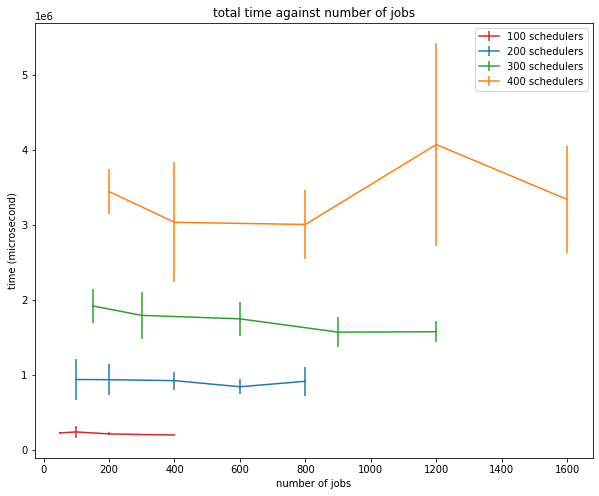

In [102]:
fig, ax = plt.subplots()


for i, p in enumerate(pods):
  ax.errorbar(pod_jobs[i], total_pod_times[i][:, 0], yerr = total_pod_times[i][:, 1], label=f'{p} schedulers', color=cs[i])

ax.set_title('total time against number of jobs')
ax.set_xlabel('number of jobs')
ax.set_ylabel('time (microsecond)')
ax.legend()

fig.set_size_inches(10, 8)

fig.savefig(f'{graph_dir}total-time-against-jobs.png')

### different times, log scale

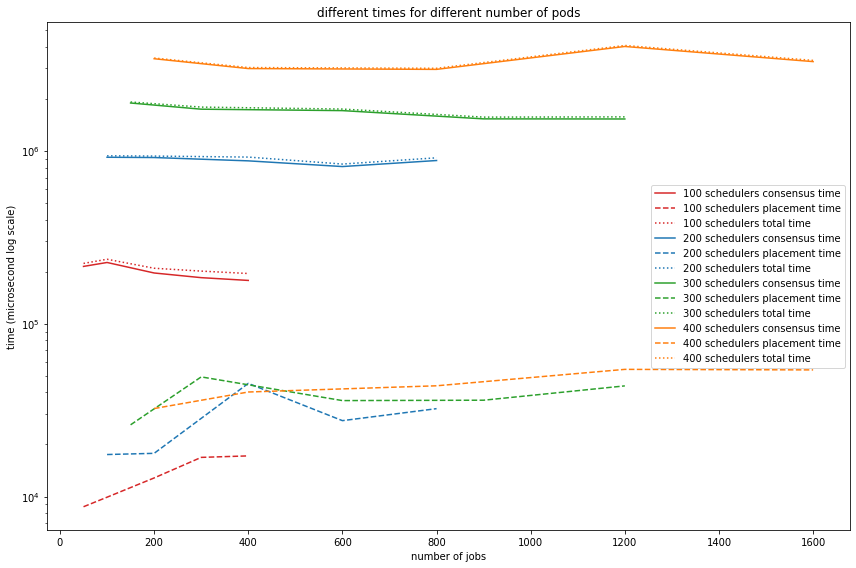

In [14]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 8)



for i, p in enumerate(pods):
  ax.semilogy(pod_jobs[i], con_pod_times[i][:, 0], label=f'{p} schedulers consensus time', ls='-', color = cs[i])
  ax.semilogy(pod_jobs[i], pl_pod_times[i][:,0], label=f'{p} schedulers placement time', ls='--', color = cs[i])
  ax.semilogy(pod_jobs[i], total_pod_times[i][:, 0], label=f'{p} schedulers total time', ls=':', color = cs[i])

ax.set_ylabel('time (microsecond log scale)')
ax.set_xlabel('number of jobs')
ax.set_title(f'different times for different number of pods')

ax.legend()
fig.tight_layout()

fig.savefig(f'{graph_dir}different-time-against-jobs-log.png')

### scheduled percentage

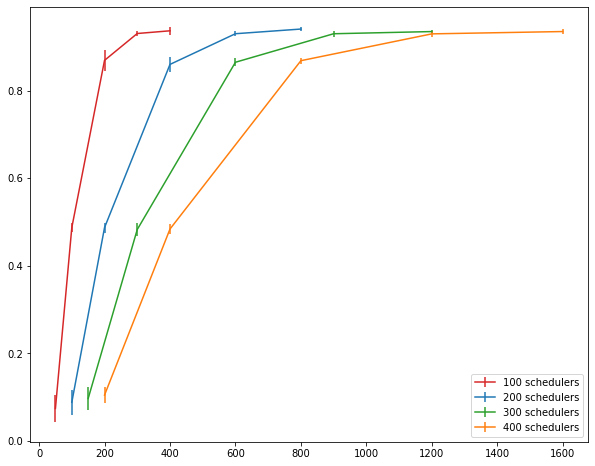

In [15]:
fig, ax = plt.subplots()

for i, p in enumerate(pods):
  ax.errorbar(pod_jobs[i], sched_pod_pcts[i][:, 0], yerr = sched_pod_pcts[i][:, 1], label=f'{p} schedulers', color=cs[i])

ax.legend()
fig.set_size_inches(10, 8)

fig.savefig(f'{graph_dir}sched-pct-against-jobs.png')